In [1]:
from functools import partial
import concurrent.futures
import itertools

import ase.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pathlib

import milad
from milad.play import asetools
from tqdm import tqdm
import torch

import utils
fp_length = -1

In [2]:
import random
# Set the seeds for some kind of reproducibility
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
structures = []

# Load dataset

Load up the various databases that I want to use

In [3]:
dbs = [utils.read_dragoni_database(i) for i in range(1, 3)]
tuple(map(random.shuffle, dbs))
print(tuple(map(list.__len__, dbs)))

(6001, 242)


Let's pick out the data we want to use for training and validation

In [4]:
split_ratio = 0.9

def split_db(db, ratio: float, total: int):
    subset = db[:total]
    split_point = int(ratio * total)
    return subset[:split_point], subset[split_point:]

training_db = []
validation_db = []

t, v = split_db(dbs[0], split_ratio, total=200)
training_db.extend(t)
validation_db.extend(v)

t, v = split_db(dbs[1], split_ratio, total=200)
training_db.extend(t)
validation_db.extend(v)

print(tuple(map(list.__len__, (training_db, validation_db))))

(360, 40)


Mean: -3460.80224609375, std: 0.17554014921188354, max: -3458.329345703125, min: -3460.932861328125


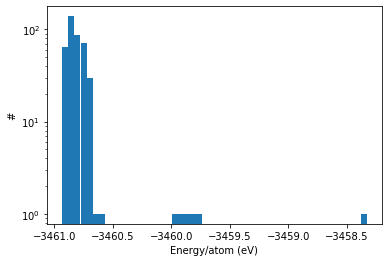

In [5]:
all_structures = list(itertools.chain(training_db, validation_db))
total_systems = len(all_structures)
total_energies = np.array([structure.get_potential_energy() for structure in all_structures], dtype=np.float32)
lengths = np.array([len(entry) for entry in all_structures], dtype=np.float32)
energies_per_atom = total_energies / lengths

print("Mean: {}, std: {}, max: {}, min: {}".format(
    np.mean(energies_per_atom), np.std(energies_per_atom), np.max(energies_per_atom), np.min(energies_per_atom)))

%matplotlib inline
utils.plot_histogram(energies_per_atom, 'Energy/atom (eV)', '#')

# Descriptor

Set up the parameters and functions for the descriptor

In [6]:
invariants = milad.invariants.read(milad.invariants.COMPLEX_INVARIANTS)

In [7]:
cutoff = 3.5

species = ('Fe',)
specie_numbers = (26,)
descriptor = milad.descriptor(
    features=dict(type=milad.functions.WeightedDelta, map_species_to=None),
#     species=dict(map=dict(numbers=specie_numbers, range=(0.5, 5.))),
    moments_calculator=milad.zernike.ZernikeMomentCalculator(invariants.max_order),
    invs=invariants,
    cutoff=cutoff,
    apply_cutoff=True,
    smooth_cutoff=True
)

Create the set of fingerprints, this could take some time...

In [9]:
training = milad.models.create_fingerprint_set(descriptor, training_db, get_derivatives=True)
validation = milad.models.create_fingerprint_set(descriptor, validation_db, get_derivatives=True)

Display the fingerprints

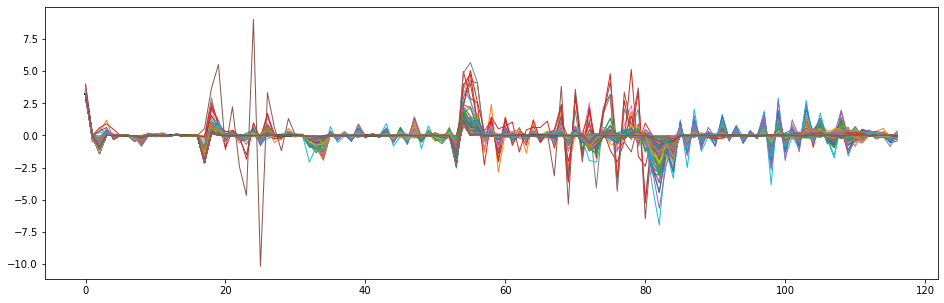

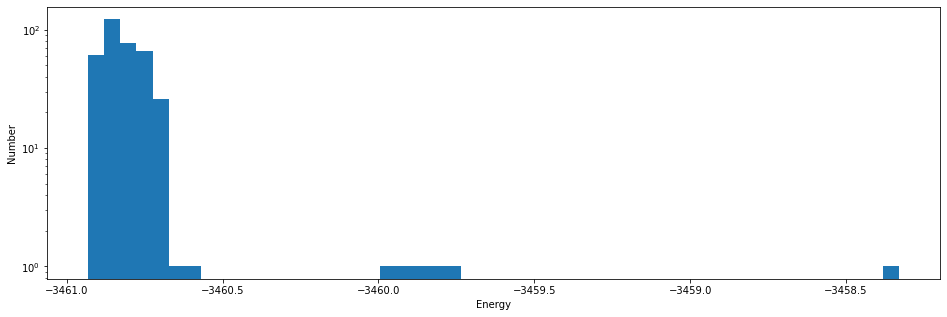

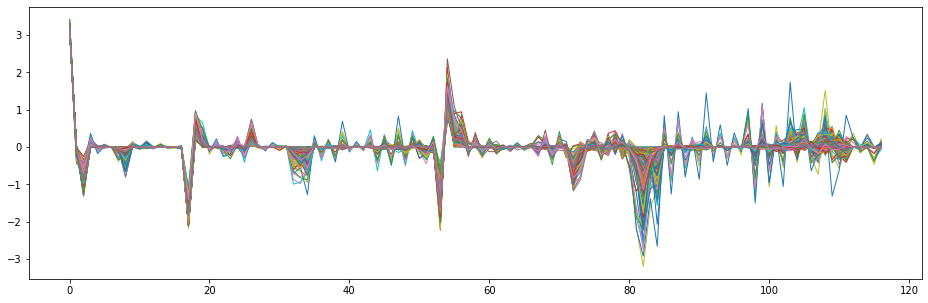

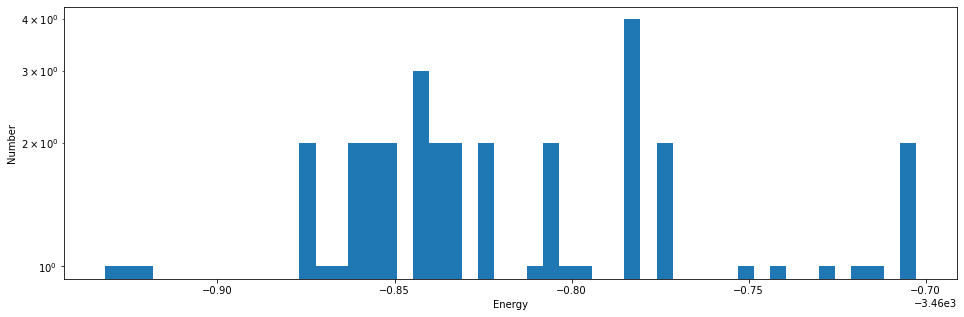

In [10]:
%matplotlib inline

training.plot_environments()
training.plot_energies()
validation.plot_environments()
validation.plot_energies()
print()

# Neural network

Set up the neural network and its inputs.  This bit still works with numpy rather than torch vectors

In [17]:
nn = milad.models.NeuralNetwork(
    activations='Tanh', 
    hiddenlayers=(32, 16, 8),
    bias=False,
    vectorise_jacobian=False,
#     device=torch.device('cpu'),
)
nn.loss_function.energy_coeff = 1.
nn.loss_function.force_coeff = 0.001
validation_data = nn.create_fitting_data(validation)

<IPython.core.display.Javascript object>


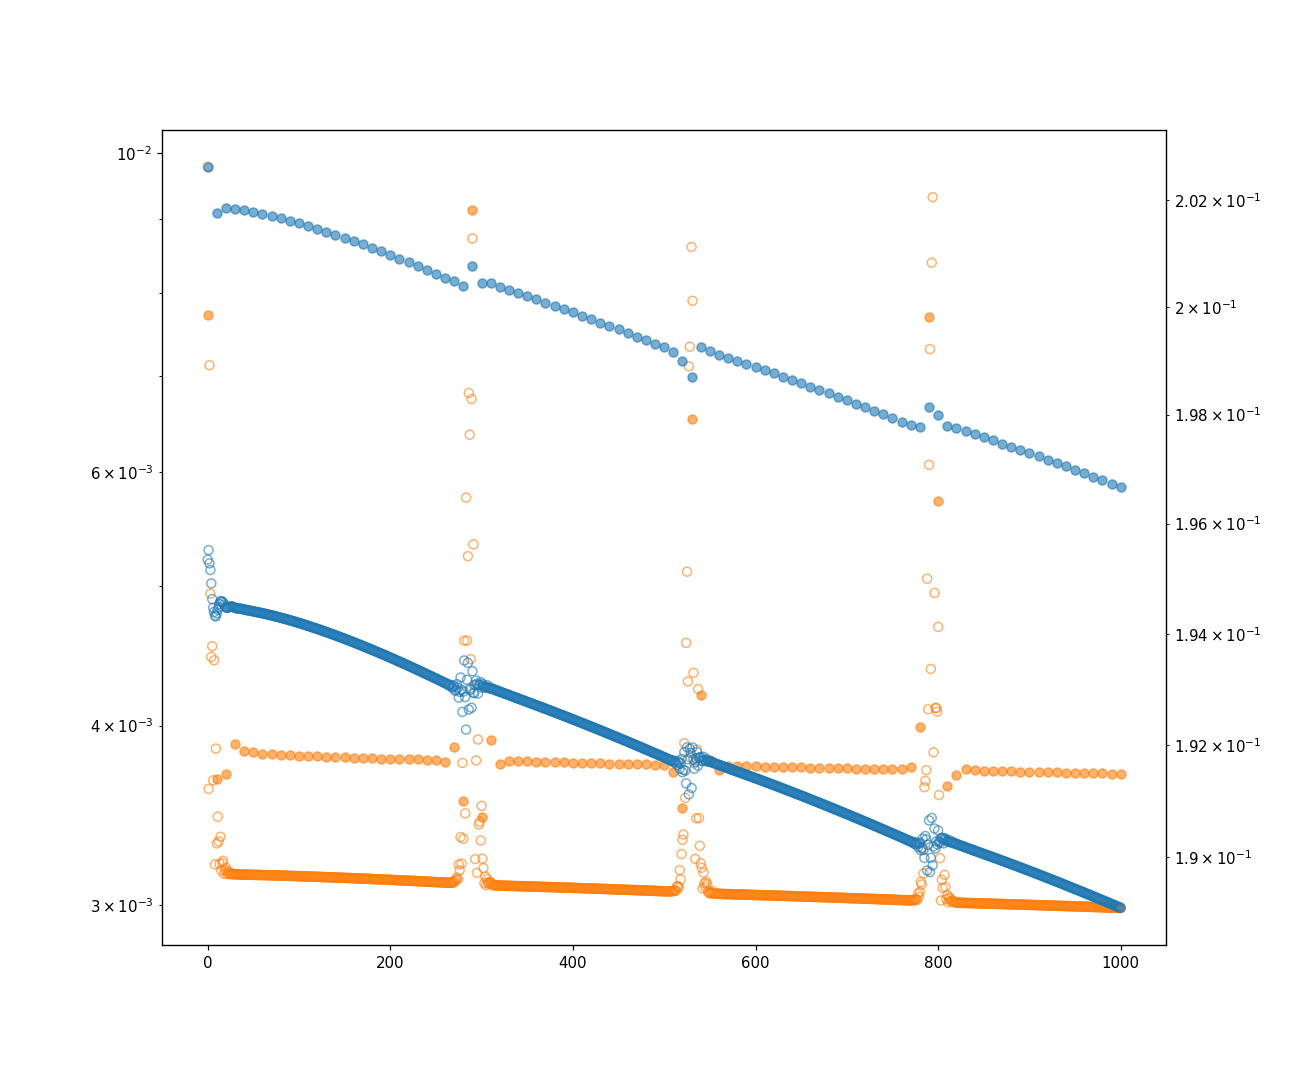

In [58]:
%matplotlib notebook
# nn.loss_function.energy_coeff = 10.
nn.loss_function.force_coeff = 0.0005
monitor = milad.models.TrainingMonitor(validation_data)

In [59]:
training_data, loss = nn.fit(
    training, 
    max_epochs=1000,
    learning_rate=1e-4,
    progress_callback=monitor.progress_callaback,
    batchsize=128,
)

In [65]:
loss = nn.loss(validation_data)
print(f'Validation energy loss: {loss.energy.cpu().item() ** 0.5}')
print(f'Validation force loss: {loss.force.cpu().item() ** 0.5}')

Validation energy loss: 0.003702882538265529
Validation force loss: 0.1966653759757972


#### Energy deviations

In [81]:
prediction = nn.make_prediction(validation_data, get_forces=True)

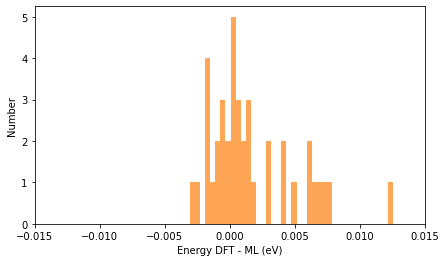

In [122]:
bins = 40

fig = plt.figure(figsize=(7, 4))
axis = fig.gca()
axis.set_ylabel('Number')

target_energies = validation_data.get_normalised_energies().cpu().detach().numpy()
predicted_energies = prediction.get_normalised_energies().cpu().detach().numpy()
differences = target_energies - predicted_energies
axis.hist(differences, bins, color='tab:orange', alpha=0.7)
lim = max(np.abs(differences.min()), differences.max())
axis.set_xlim((-0.015, 0.015))
axis.set_xlabel("Energy DFT - ML (eV)")

fig.savefig('img/energy_differences.pdf', bbox_inches='tight')

#### Force deviations

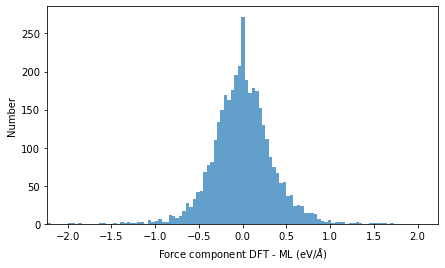

In [116]:
bins = 100

fig = plt.figure(figsize=(7, 4))
axis = fig.gca()
axis.set_ylabel('Number')

target_forces = validation_data.forces.cpu().detach().numpy()
predicted_forces = prediction.forces.cpu().detach().numpy()
differences = target_forces.ravel() - predicted_forces.ravel()

axis.hist(differences, bins, color='tab:blue', alpha=0.7)
lim = max(np.abs(differences.min()), differences.max())
axis.set_xlim((-lim, lim))
axis.set_xlabel("Force component DFT - ML (eV/$\AA$)")
fig.savefig('img/force_differences.pdf', bbox_inches='tight')

In [62]:
torch.save(nn._network.state_dict(), 'iron_potential.pickle')